In [1]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
import glob
import numpy as np

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
hep.style.use(hep.style.ATLAS)


/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-11 23:52:18.279253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-11 23:52:19.018329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
saved_data = './cached_data/'

dataset = pd.read_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='r')

mask_ttbar = dataset.type=='ttbar'
mask_singletop = dataset.type=='single_top_t_chan'
mask_wjets = dataset.type=='wjets'

# mask that extracts the expected Asimov dataset - 
# trivially the full dataset for the ttbar dataset used here, 
# but not generally true
mask_Asimov = (dataset.type=='ttbar') | (dataset.type=='single_top_t_chan') | (dataset.type=='wjets')
weights_Asimov = jnp.array(dataset[mask_Asimov].weights.ravel())

dataset_ttbar = dataset[mask_ttbar].copy()
dataset_single_top = dataset[mask_singletop].copy()
dataset_wjets = dataset[mask_wjets].copy()

nu_ttbar = dataset_ttbar.weights.sum()
print(f"expected ttbar yield = {nu_ttbar} events")

nu_singletop = dataset_single_top.weights.sum()
print(f"expected single top yield = {nu_singletop}")

nu_wjets = dataset_wjets.weights.sum()
print(f"expected wjets yield = {nu_wjets}")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


expected ttbar yield = 4819891.732440264 events
expected single top yield = 285027.6125374523
expected wjets yield = 10287376.57211815


In [3]:
path_to_ratios_wjets = './output_ratios_wjets/'
path_to_ratios_singletop = './output_ratios_singletop/'

files_wjets = glob.glob(f"{path_to_ratios_wjets}ratio_*bs1024*.npy")
files_singletop = glob.glob(f"{path_to_ratios_singletop}ratio_*bs1024*.npy")

ratios = {}
ratios['wjets'] = jnp.array(np.load(files_wjets[0])[mask_Asimov])
ratios['singletop'] = jnp.array(np.load(files_singletop[0])[mask_Asimov])
ratios['ttbar'] = jnp.array(np.ones_like(ratios['wjets'])[mask_Asimov])


In [4]:
# Build the model

# rate term
@jax.jit
def nu(mu):

    nu = mu * nu_ttbar + nu_singletop + nu_wjets

    return nu


# per event term
@jax.jit
def log_ratio_mu(mu):

    dnu_mu = mu * nu_ttbar * ratios['ttbar']\
                + nu_singletop * ratios['singletop']\
                + nu_wjets * ratios['wjets']

    return jnp.log( dnu_mu / nu(mu) ) 


# The full NLL function
@jax.jit
def full_nll_function(mu, mu_Asimov=1.0):

    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

In [5]:
from iminuit import Minuit

param_vec = ['mu']
param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(full_nll_function, param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES
strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.888e+08                 │              Nfcn = 30               │
│ EDM = 0.000154 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │  1.9838   │  0.0007   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────┐
│    │       mu │
├────┼──────────┤
│ mu │ 4.65e-07 │
└────┴──────────┘

Text(1, 0, '$\\mu_{t\\bar{t}}$')

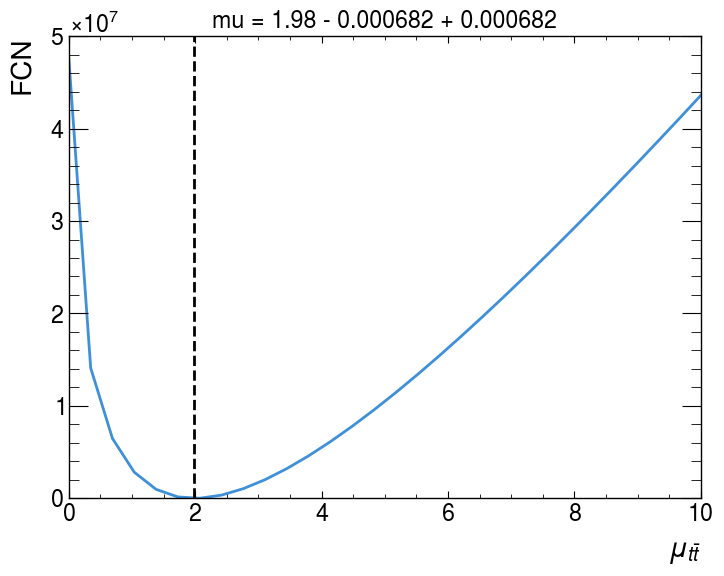

In [6]:
m1.draw_mnprofile('mu', bound=(0.0, 10.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

So the best-fit value from the toy analysis with Asimov dataset does not converge to the truth value - $\widehat{\mu}_{t\bar{t}} \neq \mu^\text{truth}_{t\bar{t}} = 1.0$.

Unlike a binned Poisson likelihood fit, which by definition converges to the truth value for Asimov and has well-defined asymptotic statistical properties - this is not guaranteed in an NSBI analysis.

In [7]:
# rate term
def nu(mu_vec):
    
    mu, mu_singletop, mu_wjets = mu_vec
    nu = mu * nu_ttbar \
        + mu_singletop * nu_singletop \
        + mu_wjets * nu_wjets

    return nu
    
# per event term
def log_ratio_mu(mu_vec):

    mu, mu_singletop, mu_wjets = mu_vec
    dnu_mu = mu * nu_ttbar * ratios['ttbar']\
            + mu_singletop * nu_singletop * ratios['singletop']\
            + mu_wjets * nu_wjets * ratios['wjets']

    return jnp.log( dnu_mu / nu(mu_vec) ) 

# The full NLL function
def full_nll_function(mu):

    mu_Asimov=[1.0, 1.0, 1.0]
    
    pois_llr = -2 * nu(mu_Asimov) * jnp.log(nu(mu)) + 2 * nu(mu)
    nsbi_llr = -2 * jnp.sum(jnp.multiply(weights_Asimov, log_ratio_mu(mu)))

    return pois_llr + nsbi_llr

In [8]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop', 'mu_wjets']
param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(full_nll_function, param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.92e+08                  │              Nfcn = 74               │
│ EDM = 6.29e-06 (Goal: 0.0002)    │            time = 1.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  2.1642   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.4e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 482.26e-3 │  0.24e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     5.09e-07     3.16e-15     -0.03e-6 │
│ mu_singletop │     3.16e-15     1.17e-16     0.72e-15 │
│     mu_wjets │     -0.03e-6     0.72e-15     6.01e-08 │
└──────────────┴────────────────────────────────────────┘

In [9]:
from iminuit import Minuit

# param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function), param_tuple, grad=None, name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.92e+08                  │              Nfcn = 74               │
│ EDM = 6.29e-06 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  2.1642   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.4e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 482.26e-3 │  0.24e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     5.09e-07     3.16e-15     -0.03e-6 │
│ mu_singletop │     3.16e-15     1.17e-16     0.72e-15 │
│     mu_wjets │     -0.03e-6     0.72e-15     6.01e-08 │
└──────────────┴────────────────────────────────────────┘

In [10]:
from iminuit import Minuit

param_vec = ['mu', 'mu_singletop']
param_vec = ['mu', 'mu_singletop', 'mu_wjets']

param_tuple = jnp.ones(len(param_vec))

m1 = Minuit(jax.jit(full_nll_function), param_tuple, grad=jax.jit(jax.grad(full_nll_function)), name=tuple(param_vec))
m1.errordef = Minuit.LEAST_SQUARES

limits = []
for param_ in enumerate(param_vec):
    
    limits.append([1e-10,None])
        
limits = tuple(limits)
m1.limits = limits

strategy = 0
# strategy = 2
m1.strategy = strategy
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -4.92e+08                  │         Nfcn = 28, Ngrad = 7         │
│ EDM = 6.29e-06 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │        Covariance APPROXIMATE        │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu           │  2.1642   │  0.0007   │            │            │  1e-10  │         │       │
│ 1 │ mu_singletop │     0     │  2.4e-6   │            │            │  1e-10  │         │       │
│ 2 │ mu_wjets     │ 482.26e-3 │  0.24e-3  │            │            │  1e-10  │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬────────────────────────────────────────┐
│              │           mu mu_singletop     mu_wjets │
├──────────────┼────────────────────────────────────────┤
│           mu │     5.08e-07     3.17e-15     -0.03e-6 │
│ mu_singletop │     3.17e-15     1.17e-16     0.23e-15 │
│     mu_wjets │     -0.03e-6     0.23e-15     6.01e-08 │
└──────────────┴────────────────────────────────────────┘

Text(1, 0, '$\\mu_{t\\bar{t}}$')

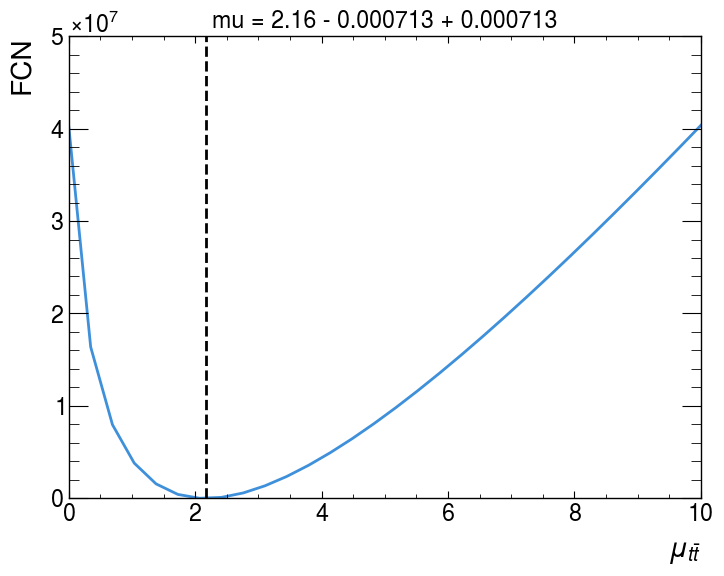

In [11]:
m1.draw_mnprofile('mu', bound=(0.0, 10.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t\bar{t}}$')

Text(1, 0, '$\\mu_{t}$')

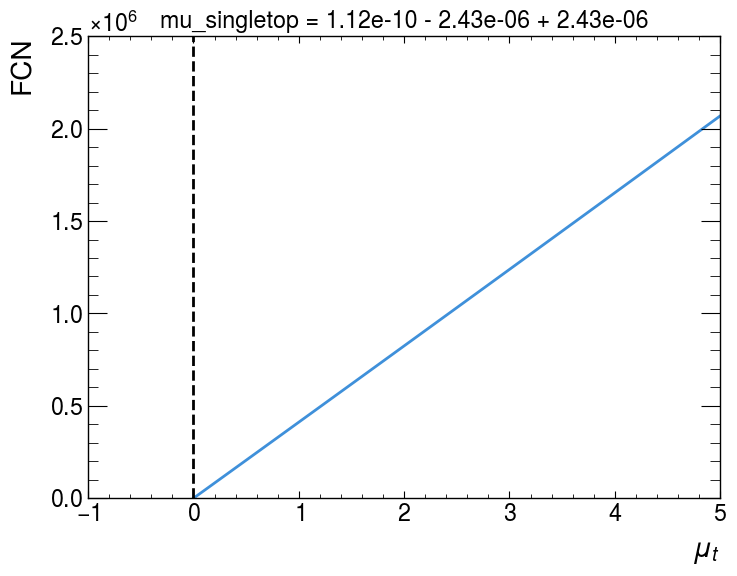

In [12]:
m1.draw_mnprofile('mu_singletop', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$')

Text(1, 0, '$\\mu_{t}$')

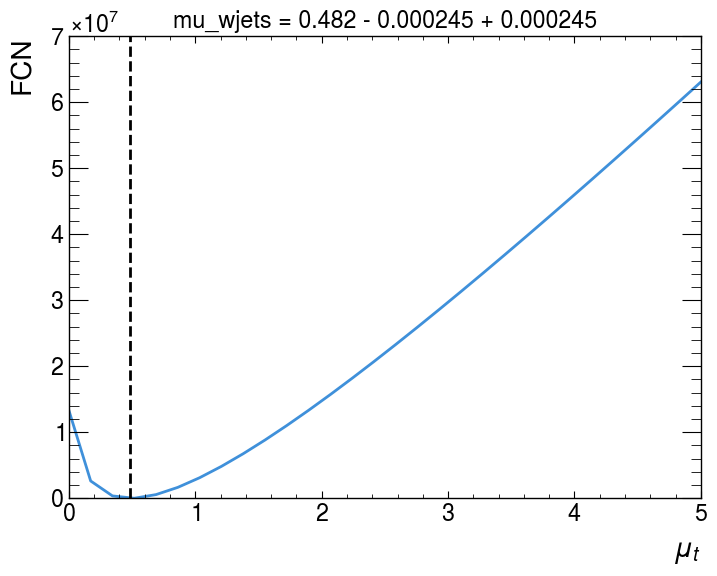

In [13]:
m1.draw_mnprofile('mu_wjets', bound=(0.0, 5.0))
plt.axis(ymin=0.0)
plt.xlabel(r'$\mu_{t}$')

As we increase the number of parameters, the robustness of the density ratio modelling becomes more important. 

Things remaining to add to this:

- Constrained nuisance parameters describing systematic uncertainties
- Neyman Construction in an unbinned NSBI framework